<a href="https://colab.research.google.com/github/EmilianoLS/Data-Science/blob/main/churn_model_meli/notebooks/churn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Librerias generales
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
# Librerias para listar archivos
from os import listdir
from os.path import isfile, join
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [2]:
# Defino url de los csvs

url_active_user = 'https://raw.githubusercontent.com/EmilianoLS/Data-Science/main/churn_model_meli/data/ACTIVE_USER.csv'
url_demografico = 'https://raw.githubusercontent.com/EmilianoLS/Data-Science/main/churn_model_meli/data/DEMOGRAFICOS.csv'
url_dinero_cuenta = 'https://raw.githubusercontent.com/EmilianoLS/Data-Science/main/churn_model_meli/data/DINERO_CUENTA.csv'
url_evaluate = 'https://raw.githubusercontent.com/EmilianoLS/Data-Science/main/churn_model_meli/data/EVALUATE.csv'
url_marketplace_data = 'https://raw.githubusercontent.com/EmilianoLS/Data-Science/main/churn_model_meli/data/MARKETPLACE_DATA.csv'
url_payments = 'https://raw.githubusercontent.com/EmilianoLS/Data-Science/main/churn_model_meli/data/PAYMENTS.csv'

# Corrida local

In [3]:
# Importo datasets

#active_users = pd.read_csv('../data/ACTIVE_USER.csv') # Datos de visitas a la app
#demograficos = pd.read_csv('../data/DEMOGRAFICOS.csv')
#dinero_cuenta = pd.read_csv('../data/DINERO_CUENTA.csv') # Datos de la cantidad de dinero en la cuenta y si invierta
#evaluate = pd.read_csv('../data/EVALUATE.csv')
#marketplace_data = pd.read_csv('../data/MARKETPLACE_DATA.csv') # Movimientos en mercadolibre
#payments = pd.read_csv('../data/PAYMENTS.csv') # Datos transaccionales en MP

# Corrida en la nube

In [4]:
# Importo datasets

active_users = pd.read_csv(url_active_user) # Datos de visitas a la app
demograficos = pd.read_csv(url_demografico)
dinero_cuenta = pd.read_csv(url_dinero_cuenta) # Datos de la cantidad de dinero en la cuenta y si invierta
evaluate = pd.read_csv(url_evaluate)
marketplace_data = pd.read_csv(url_marketplace_data) # Movimientos en mercadolibre
payments = pd.read_csv(url_payments) # Datos transaccionales en MP

# Visualización de los datos

Lo primero que hago es controlar los datos que tengo, explorar las variables e identificar que los datos sean correctos.

In [5]:
# Active users
active_users.head(3)

,CUS_CUST_ID_BUY,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1,last_login_ml_date_1
0,424070401,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
1,271894453,1.0,14.0,11.0,21.0,2.0,12.0,2019-05-17,2019-05-24
2,327402711,NaN,NaN,0.0,10.0,4.0,26.0,2019-05-28,2019-05-31


In [6]:
# Demograficos
demograficos.head(3)

,CITY,CUS_CUST_ID_BUY,GENDER,RANGO_EDAD,TARJETAS,ESTADO
0,caba,47629682,male,03.Entre 26 y 30 años,Credit Card,capital federal
1,belen de escobar,184288617,male,03.Entre 26 y 30 años,Account Money,buenos aires
2,san fernando del valle de catamarca,134359455,female,03.Entre 26 y 30 años,Debit Card,catamarca


In [7]:
# Dinero en cuenta
dinero_cuenta.head(3)

,CUS_CUST_ID_BUY,PLATA_CUENTA_1,PLATA_CUENTA_2,INVERSION
0,54018.0,250.99,0.00,pending
1,23513.0,20.05,2220.05,warmup
2,21230.0,0.00,0.00,warmup


In [8]:
# Evaluate
evaluate.head(3)

,CUS_CUST_ID_BUY,churn
0,20663512,1.0
1,444286946,0.0
2,348084528,1.0


In [9]:
# Marketplace 
marketplace_data.head(3)

,CUS_CUST_ID_BUY,SPENT_ML,RECENCY_ML,FREQUENCY_ML
0,53621056,71.51,2019-03-30,1
1,308208758,269.20,2019-05-30,11
2,30591970,149.22,2019-03-24,4


In [10]:
# Payments
payments.head(3)

,FECHA,CUS_CUST_ID_SEL,CUS_CUST_ID_BUY,SPENT,TPV_SEGMENT_DETAIL,DESCUENTO
0,2019-05-25,314941456,20663512,11.3566,Instore,2.2312
1,2019-06-20,251693291,444286946,4.6190,Transport,0.9238
2,2019-01-10,251693291,20663512,5.3519,Transport,1.0704


In [11]:
# Revision de payments dataframe
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555516 entries, 0 to 555515
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FECHA               555516 non-null  object 
 1   CUS_CUST_ID_SEL     555516 non-null  int64  
 2   CUS_CUST_ID_BUY     555516 non-null  int64  
 3   SPENT               555516 non-null  float64
 4   TPV_SEGMENT_DETAIL  555516 non-null  object 
 5   DESCUENTO           555516 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 25.4+ MB


La información pareciera estar correcta en cuanto a las clases, excepto por la fecha, la cual se convierte a datetime.

In [12]:
# Convierto la columna fecha en datetime
payments['FECHA'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in payments['FECHA']]

In [13]:
# La idea es unificar la data por usuario de forma que cada linea tenga toda la información
# Por eso primero se dummiza el dataframe payments para que los distintos segmentos estén por columna

payments = pd.get_dummies(payments, columns = ['TPV_SEGMENT_DETAIL'], prefix = ['segment'])
payments.head(3)

,FECHA,CUS_CUST_ID_SEL,CUS_CUST_ID_BUY,SPENT,DESCUENTO,segment_Cellphone Recharge,segment_Instore,segment_Money Transfer,segment_Other Single Players,segment_Transport,segment_Utilities
0,2019-05-25,314941456,20663512,11.3566,2.2312,0,1,0,0,0,0
1,2019-06-20,251693291,444286946,4.6190,0.9238,0,0,0,0,1,0
2,2019-01-10,251693291,20663512,5.3519,1.0704,0,0,0,0,1,0


Para poder entender en qué se gasto con cada interacción, se multiplican las *features* de 'SPENT' y 'DISCOUNT' por todas las variables dummies. 

El resultado final será que para cada interacción con MP las columnas dummies serán todas cero excepto por aquel segmento por el cual se realizó la interacción.

In [14]:
# Multiplico los valores de spent y discount por las variables dummies
for col in payments.iloc[:, 5:11]:
    name1 = col + '_spent'
    name2 = col + '_discount'
    payments[name1] = payments[col].multiply(payments['SPENT'], axis = 'index')
    payments[name2] = payments[col].multiply(payments['SPENT'], axis = 'index')

En mi experiencia, cuando se tiene información temporal, se debe aprovechar. Puntualmente, entender los movimientos en los últimos meses/semanas/dias (dependiendo del problema) antes de algún evento, como en este caso una baja, suelen tener mucha relevancia para predecir si el cliente efectivamente hará o no *churn*.

Por ese motivo, se creo una función que realiza cálculos sobre diferentes ventanas de tiempo preestablecidas. En otras palabras, se aplican ventanas de tiempo y en cada intervalo se realizan funciones agregadas. 
De esta forma obtengo la suma, el promedio y el máximo de todas las interacciones transcurridas en cada intervalo.

Para evitar agregar muchas más dimensiones, se toman intervalos de 3 meses (parámentro *frequency* en la función) los cuales resultan en:

* Enero completo
* Febrero hasta Abril
* Abril en adelante

Lógicamente, estos cálculos se realizan para cada segmento, tanto para lo gastado como para el descuento aplicado.

In [15]:
#payments.iloc[:,-6:].multiply(payments['SPENT'], axis = 'index')

def create_group_date(frequency):
  grouped_data = payments.groupby([pd.Grouper(key = 'FECHA', freq = frequency), 'CUS_CUST_ID_BUY'], as_index = True).agg(
                        segment_cellphone_recharge_total = ('segment_Cellphone Recharge', 'sum'),
                        spent_segment_cellphone_recharge = ('segment_Cellphone Recharge_spent', 'sum'), 
                        spent_segment_cellphone_recharge_mean = ('segment_Cellphone Recharge_spent', 'mean'),
                        spent_segment_cellphone_recharge_max = ('segment_Cellphone Recharge_spent', 'max'),
                        segment_instore_total = ('segment_Instore','sum'),
                        spent_segment_instore = ('segment_Instore_spent','sum'),
                        spent_segment_instore_mean = ('segment_Instore_spent','mean'),
                        spent_segment_instore_max = ('segment_Instore_spent','max'),
                        segment_money_transfer_total = ('segment_Money Transfer','sum'),
                        spent_segment_money_transfer = ('segment_Money Transfer_spent','sum'),
                        spent_segment_money_transfer_mean = ('segment_Money Transfer_spent','mean'),
                        spent_segment_money_transfer_max = ('segment_Money Transfer_spent','max'),
                        segment_other_single_players_total = ('segment_Other Single Players','sum'),
                        spent_segment_other_single_players = ('segment_Other Single Players_spent','sum'),
                        spent_segment_other_single_players_mean = ('segment_Other Single Players_spent','mean'),
                        spent_segment_other_single_players_max = ('segment_Other Single Players_spent','max'),
                        segment_transport_total = ('segment_Transport', 'sum'),
                        spent_segment_transport = ('segment_Transport_spent','sum'),
                        spent_segment_transport_mean = ('segment_Transport_spent','mean'),
                        spent_segment_transport_max = ('segment_Transport_spent','max'),
                        segment_utilities_total = ('segment_Utilities','sum'),
                        spent_segment_utilities = ('segment_Utilities_spent','sum'),
                        spent_segment_utilities_mean = ('segment_Utilities_spent','mean'),
                        spent_segment_utilities_max = ('segment_Utilities_spent','max'),
                        
                        discount_segment_cellphone_recharge = ('segment_Cellphone Recharge_discount', 'sum'), 
                        discount_segment_cellphone_recharge_mean = ('segment_Cellphone Recharge_discount', 'mean'),
                        discount_segment_cellphone_recharge_max = ('segment_Cellphone Recharge_discount', 'max'),
                        discount_segment_instore = ('segment_Instore_discount','sum'),
                        discount_segment_instore_mean = ('segment_Instore_discount','mean'),
                        discount_segment_instore_max = ('segment_Instore_discount','max'),
                        discount_segment_money_transfer = ('segment_Money Transfer_discount','sum'),
                        discount_segment_money_transfer_mean = ('segment_Money Transfer_discount','mean'),
                        discount_segment_money_transfer_max = ('segment_Money Transfer_discount','max'),
                        discount_segment_other_single_players = ('segment_Other Single Players_discount','sum'),
                        discount_segment_other_single_players_mean = ('segment_Other Single Players_discount','mean'),
                        discount_segment_other_single_players_max = ('segment_Other Single Players_discount','max'),
                        discount_segment_transport = ('segment_Transport_discount','sum'),
                        discount_segment_transport_mean = ('segment_Transport_discount','mean'),
                        discount_segment_transport_max = ('segment_Transport_discount','max'),
                        discount_segment_utilities = ('segment_Utilities_discount','sum'),
                        discount_segment_utilities_mean = ('segment_Utilities_discount','mean'),
                        discount_segment_utilities_max = ('segment_Utilities_discount','max'))
  
  return grouped_data

In [16]:
# Funcion de agregacion por ventanas de tiempo
payments_group_date = create_group_date('3M')
payments_group_date = payments_group_date.reset_index() 

# Creo la variable mes como objeto para dummizar 
payments_group_date['MES'] = [str(x.month) for x in payments_group_date['FECHA']]

# Variable util para automatizar la agregacion
k = len(payments_group_date['MES'].unique())

# Creo variables dummies
payments_group_date = pd.get_dummies(payments_group_date, columns = ['MES'])

# Obtengo los indices inicial y final de las columnas dummies porque despues se iran agregando nuevas 
# columnas en la medida que las multiplique por los features obtenidos anteriormente 
max_index = payments_group_date.shape[1] - 1
low_index = max_index  + 1 - k

# Lista de columnas a elminar una vez finalizado el proceso
drop_cols = payments_group_date.columns[2:max_index + 1].values.tolist()

# Loop que ira greando una nueva columna por cada feature y variable dummie existente.
# La idea es que se multiplica la variable dummie por el valor de cada feature 
for col1 in payments_group_date.columns[2:low_index]:
    for col2 in payments_group_date.columns[low_index:max_index + 1]:
        col_name = col1 + '_' + col2
        payments_group_date[col_name] = payments_group_date[col2].multiply(payments_group_date[col1], axis = 'index')

# Elimino columnas que ya no uso
payments_group_date.drop(columns = drop_cols, axis = 1, inplace = True)

# Group by customer y obtengo un registro unico por cada uno
payments_group_date = payments_group_date.groupby('CUS_CUST_ID_BUY').sum()
payments_group_date.head()


,segment_cellphone_recharge_total_MES_1,segment_cellphone_recharge_total_MES_4,segment_cellphone_recharge_total_MES_7,spent_segment_cellphone_recharge_MES_1,spent_segment_cellphone_recharge_MES_4,spent_segment_cellphone_recharge_MES_7,spent_segment_cellphone_recharge_mean_MES_1,spent_segment_cellphone_recharge_mean_MES_4,spent_segment_cellphone_recharge_mean_MES_7,spent_segment_cellphone_recharge_max_MES_1,spent_segment_cellphone_recharge_max_MES_4,spent_segment_cellphone_recharge_max_MES_7,segment_instore_total_MES_1,segment_instore_total_MES_4,segment_instore_total_MES_7,spent_segment_instore_MES_1,spent_segment_instore_MES_4,spent_segment_instore_MES_7,spent_segment_instore_mean_MES_1,spent_segment_instore_mean_MES_4,spent_segment_instore_mean_MES_7,spent_segment_instore_max_MES_1,spent_segment_instore_max_MES_4,spent_segment_instore_max_MES_7,segment_money_transfer_total_MES_1,segment_money_transfer_total_MES_4,segment_money_transfer_total_MES_7,spent_segment_money_transfer_MES_1,spent_segment_money_transfer_MES_4,spent_segment_money_transfer_MES_7,spent_segment_money_transfer_mean_MES_1,spent_segment_money_transfer_mean_MES_4,spent_segment_money_transfer_mean_MES_7,spent_segment_money_transfer_max_MES_1,spent_segment_money_transfer_max_MES_4,spent_segment_money_transfer_max_MES_7,segment_other_single_players_total_MES_1,segment_other_single_players_total_MES_4,segment_other_single_players_total_MES_7,spent_segment_other_single_players_MES_1,...,discount_segment_instore_mean_MES_7,discount_segment_instore_max_MES_1,discount_segment_instore_max_MES_4,discount_segment_instore_max_MES_7,discount_segment_money_transfer_MES_1,discount_segment_money_transfer_MES_4,discount_segment_money_transfer_MES_7,discount_segment_money_transfer_mean_MES_1,discount_segment_money_transfer_mean_MES_4,discount_segment_money_transfer_mean_MES_7,discount_segment_money_transfer_max_MES_1,discount_segment_money_transfer_max_MES_4,discount_segment_money_transfer_max_MES_7,discount_segment_other_single_players_MES_1,discount_segment_other_single_players_MES_4,discount_segment_other_single_players_MES_7,discount_segment_other_single_players_mean_MES_1,discount_segment_other_single_players_mean_MES_4,discount_segment_other_single_players_mean_MES_7,discount_segment_other_single_players_max_MES_1,discount_segment_other_single_players_max_MES_4,discount_segment_other_single_players_max_MES_7,discount_segment_transport_MES_1,discount_segment_transport_MES_4,discount_segment_transport_MES_7,discount_segment_transport_mean_MES_1,discount_segment_transport_mean_MES_4,discount_segment_transport_mean_MES_7,discount_segment_transport_max_MES_1,discount_segment_transport_max_MES_4,discount_segment_transport_max_MES_7,discount_segment_utilities_MES_1,discount_segment_utilities_MES_4,discount_segment_utilities_MES_7,discount_segment_utilities_mean_MES_1,discount_segment_utilities_mean_MES_4,discount_segment_utilities_mean_MES_7,discount_segment_utilities_max_MES_1,discount_segment_utilities_max_MES_4,discount_segment_utilities_max_MES_7
CUS_CUST_ID_BUY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1276,0.0,3.0,1.0,0.0,6.5167,1.1198,0.0,2.172233,1.1198,0.0,2.6774,1.1198,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.00000,0.00000,0.0000,0.0000,0.0000,0,0,0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0,0,0,0.0,...,0.00000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.00000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14525,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.0000,0.0,0.0000,0.0000,2.0,29.0,15.0,14.2774,271.9272,143.1102,7.138700,9.37680,9.54068,7.4721,44.5911,48.3925,0,0,0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0,0,0,0.0,...,9.54068,7.4721,44.5911,48.3925,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.00000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como se puede ver, las dimensiones del problema van en aumento por lo que hay que tener cuidado de no complejizar aún más el problema con las features que se agreguen.

El siguiente paso es agrupar por usuario el total de interacciones, gastos y descuentos obtenidos.

In [17]:
# Agrupo por usuario para obtener la suma, promedio y conteo total de spent y descuento

payments_group_spent = payments.groupby('CUS_CUST_ID_BUY', as_index = False).agg({'SPENT':['sum','mean','count'], 'DESCUENTO':['sum','mean']},)
payments_group_spent.columns = ['_'.join(col).strip() for col in payments_group_spent.columns.values]
payments_group_spent.rename(columns = {'CUS_CUST_ID_BUY_':'CUS_CUST_ID_BUY'}, inplace = True)        
payments_group_spent .head()                                                          

,CUS_CUST_ID_BUY,SPENT_sum,SPENT_mean,SPENT_count,DESCUENTO_sum,DESCUENTO_mean
0,1276,7.6365,1.909125,4,0.0000,0.000000
1,14525,429.3148,9.332930,46,18.6575,0.405598
2,21230,4.4198,4.419800,1,2.2099,2.209900
3,22083,196.6036,10.922422,18,14.9465,0.830361
4,23513,31.1145,3.111450,10,0.0000,0.000000


Habiendo finalizado con las ventanas temporales, y ya teniendo un registro único por cada usuario de MP, se procede a joinear todos los datasets y así generar el dataframe final con el que se entrenará.

In [18]:
# Final payments data
final_payments = pd.merge(payments_group_spent, payments_group_date, on = 'CUS_CUST_ID_BUY', how = 'left')

# Join con active users para entender su actividad en las apps
final_payments = pd.merge(final_payments, active_users, on = 'CUS_CUST_ID_BUY', how = 'left')

# Join con demograficos para obtener datos de los usuarios
final_payments = pd.merge(final_payments, demograficos, on = 'CUS_CUST_ID_BUY', how = 'left')

# Join con dinero cuenta para ver los movimientos de los usuarios
final_payments = pd.merge(final_payments, dinero_cuenta, on = 'CUS_CUST_ID_BUY', how = 'left')

# Join con marketplace data para ver actividad de los usuarios
final_payments = pd.merge(final_payments, marketplace_data, on = 'CUS_CUST_ID_BUY', how = 'left')

In [19]:
# Las features correspondientes a fechas están como objetos asi que se cambian
final_payments['last_login_mp_date_1'] = [datetime.datetime.strptime(x, '%Y-%m-%d') if type(x) != float else x for x in final_payments['last_login_mp_date_1']]
final_payments['last_login_ml_date_1'] = [datetime.datetime.strptime(x, '%Y-%m-%d') if type(x) != float else x for x in final_payments['last_login_ml_date_1']]
final_payments['RECENCY_ML'] = [datetime.datetime.strptime(x, '%Y-%m-%d') if type(x) != float else x for x in final_payments['RECENCY_ML']]

## Exploración de datos tipo *object*

Algunos datos son del tipo *object* y poseen valores nulos. Los estudio para evaluar qué es lo que vale la pena dropear y qué valores imputar.

In [20]:
# Numero de valores nulos para cada uno de los atributos
final_payments.select_dtypes(include = 'object').isna().sum()

CITY          14791
GENDER        13036
RANGO_EDAD    13036
TARJETAS      13036
ESTADO        13036
INVERSION      2866
dtype: int64

In [21]:
# El atributo CITY es mucho más granular que el atributo ESTADO el cual tiene la información a nivel 
# provincia, lo cual es mucho más manejable. Por este motivo se decide eliminar el feature CITY

print('Cantidad de ciudades unicas: {}'.format(len(final_payments.CITY.unique())))
print('Cantidad de estados unicos: {}'.format(len(final_payments.ESTADO.unique())))

Cantidad de ciudades unicas: 3156
Cantidad de estados unicos: 33


In [22]:
# Dropeo el feature CITY
final_payments.drop(columns = 'CITY', axis = 1, inplace = True)

**Nota**: Además, muchas ciudades aparecían menos de 10 veces, por lo cual no aportaban mucho valor informativo. Este es otro motivo que justificaba eliminar este atributo.

### Evaluación de valores nulos

In [23]:
final_payments.select_dtypes(include = 'object').isna().sum()/len(final_payments)

GENDER        0.299664
RANGO_EDAD    0.299664
TARJETAS      0.299664
ESTADO        0.299664
INVERSION     0.065882
dtype: float64

In [24]:
# Valores en las features
print('Valores en GENDER')
print(final_payments.GENDER.value_counts())
print('')

print('Valores en RANGO EDAD')
print(final_payments.RANGO_EDAD.value_counts())
print('')

print('Valores en TARJETAS')
print(final_payments.TARJETAS.value_counts())
print('')

print('Valores en INVERSION')
print(final_payments.INVERSION.value_counts())
print('')

Valores en GENDER
male       15914
female     12769
Unknown     1783
Name: GENDER, dtype: int64

Valores en RANGO EDAD
06.Entre 41 y 55 años    6822
04.Entre 31 y 35 años    5155
03.Entre 26 y 30 años    5072
05.Entre 36 y 40 años    4331
02.Entre 18 y 25 años    4246
00. Sin Dato             2700
07.Entre 56 y 65 años    1545
08.Mayor de 65 años       541
01.Menor de 18 años        54
Name: RANGO_EDAD, dtype: int64

Valores en TARJETAS
Credit Card         14308
Account Money        7717
Debit Card           7440
Ticket                945
Bank Transfer          20
digital_currency       19
ATM                    17
Name: TARJETAS, dtype: int64

Valores en INVERSION
eligible           18101
warmup              9933
pending             5611
investing           5591
non_eligible         964
disabled             236
disable_pending      117
rejected              53
banned                30
Name: INVERSION, dtype: int64



In [25]:
# Imputacion de valores nulos en GENDER y RANGO EDAD:
# Al existir una categoria que agrupa aquellos usuarios de los cuales no se
# tiene informacion, se imputa esta categoria a los valores nulos

final_payments['GENDER'].fillna('Unknown', inplace = True)
final_payments['RANGO_EDAD'].fillna('00. Sin Dato', inplace = True)

# Para los valores nulos de ESTADO se toma una idea similar y se imputa un valor
# 'Desconocido' ya que no hay forma de imputar adecuadamente este valor.
# Quizá si los valores de 'CITY' estuviesen completos podría inferirse, pero
# no es el caso

final_payments['ESTADO'].fillna('Unknown', inplace = True)

# Para los datos de tarjeta, la tabla de origen no tiene valores nulos, con lo cual
# se imputan los valores nulos en el dataset final con un unknown

final_payments['TARJETAS'].fillna('Unknown', inplace = True)

(array([8943., 1019., 1038., 1056., 1041., 1095., 1031., 1002.,  946.,
         988., 1010.,  941.,  849.,  845.,  895.,  871.,  764.,  775.,
         758.,  710.,  696.,  694.,  640.,  622.,  614.,  574.,  565.,
         494.,  520., 1020.]),
 array([ 0.        ,  1.03333333,  2.06666667,  3.1       ,  4.13333333,
         5.16666667,  6.2       ,  7.23333333,  8.26666667,  9.3       ,
        10.33333333, 11.36666667, 12.4       , 13.43333333, 14.46666667,
        15.5       , 16.53333333, 17.56666667, 18.6       , 19.63333333,
        20.66666667, 21.7       , 22.73333333, 23.76666667, 24.8       ,
        25.83333333, 26.86666667, 27.9       , 28.93333333, 29.96666667,
        31.        ]),
 <a list of 30 Patch objects>)

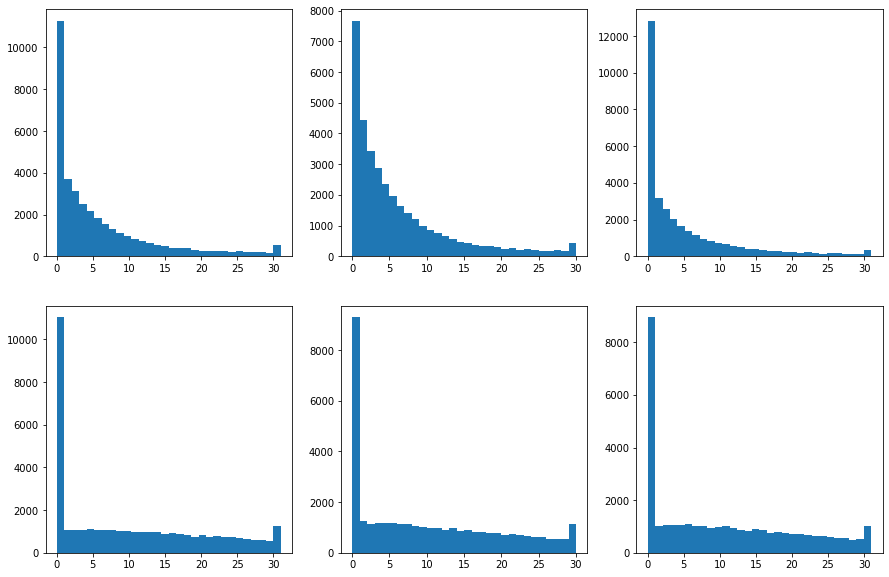

In [26]:
# Para imputar los valores nulos en la actividad en las plataformas es importante
# entender la distribución de los valores
# Al principio, pensaba que no era posible tener valores iguales a 0 (sin actividad)
# pero que hubiese compras. Sin embargo, se vieron resultados donde era posible.
# Se observa la distribucion de las variables para entender que valor conviene imputar

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))

ax[0,0].hist(active_users['MAU_MP_1'], bins = 30)
ax[0,1].hist(active_users['MAU_MP_2'], bins = 30)
ax[0,2].hist(active_users['MAU_MP_3'], bins = 30)
ax[1,0].hist(active_users['MAU_ML_1'], bins = 30)
ax[1,1].hist(active_users['MAU_ML_2'], bins = 30)
ax[1,2].hist(active_users['MAU_ML_3'], bins = 30)

In [27]:
# Imputo los valores nulos de la cantidad de veces que se ingreso en las plataformas a 0

final_payments['MAU_ML_1'].fillna(0, inplace = True)
final_payments['MAU_ML_2'].fillna(0, inplace = True)
final_payments['MAU_ML_3'].fillna(0, inplace = True)
final_payments['MAU_MP_1'].fillna(0, inplace = True)
final_payments['MAU_MP_2'].fillna(0, inplace = True)
final_payments['MAU_MP_3'].fillna(0, inplace = True)

In [28]:
# El dataset de PLATA_EN_CUENTA no contiene datos nulos en los features
# de PLATA_CUENTA_1 y 2. Pero tiene usuarios faltantes, lo que lleva a suponer
# que no tienen datos de los mismos. Por lo tanto, se imputaran los valores 
# nulos del dataset final con valores negativos en lo que es plata en cuenta
# y en condicion de inversion se colocara 'Unknown'

final_payments['PLATA_CUENTA_1'].fillna(-1, inplace = True)
final_payments['PLATA_CUENTA_2'].fillna(-1, inplace = True)
final_payments['INVERSION'].fillna('Unknown', inplace = True)

In [29]:
# El dataset de marketplace no tiene datos nulos en los features por lo que 
# se imputan los valores en el dataset final con valores negativos

final_payments['SPENT_ML'].fillna(-1, inplace = True)
final_payments['RECENCY_ML'].fillna(datetime.datetime(1900,1,1), inplace = True)
final_payments['FREQUENCY_ML'].fillna(-1, inplace = True)

In [30]:
# Para imputar los valores nulos del last login mp se crea una tabla alterna donde
# se obtiene la ultima fecha de payment registrada y se coloca dicha fecha en los 
# valores nulos 

temp = payments.groupby('CUS_CUST_ID_BUY', as_index = False).agg({'FECHA':'max'})
final_payments = pd.merge(final_payments, temp, on = 'CUS_CUST_ID_BUY', how = 'left')

nan_users = final_payments[final_payments['last_login_mp_date_1'].isna()]['CUS_CUST_ID_BUY']
for i in nan_users.index.tolist():
  final_payments.loc[i, 'last_login_mp_date_1'] = final_payments.loc[i,'FECHA']

final_payments.rename(columns = {'FECHA':'fecha_ultima_transaccion'}, inplace = True)
final_payments['last_login_ml_date_1'].fillna(datetime.datetime(1900,1,1), inplace = True)

In [31]:
# Agrego la variable target

final_payments = pd.merge(final_payments, evaluate, on = 'CUS_CUST_ID_BUY', how = 'left')

# Análisis Exploratorio

La idea no es profundizar mucho sobre la exploración (sobretodo en vistas de la gran cantidad de features). Pero se estudia la distribución de la variable target, así como también algunas suposiciones que más tarde podrán comprobarse o no en la etapa de modelado.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



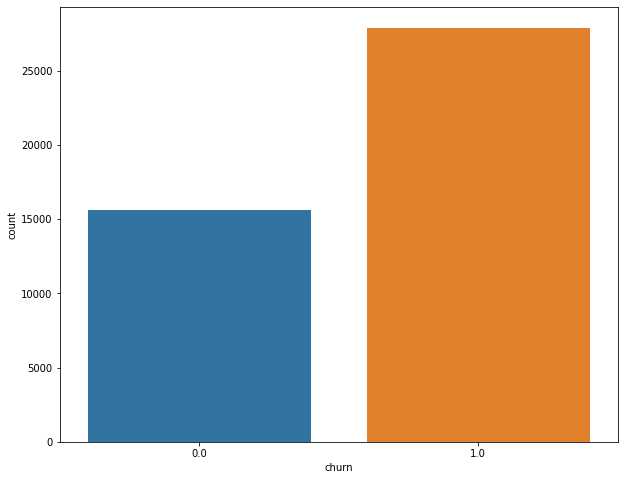

In [32]:
# Evaluación del balance de la variable target
# Generalmente los problemas de churn tienen variables target muy desbalanceadas 
# Observo hasta qué punto esto es así en este problema

plt.figure(figsize = (10, 8))
sns.countplot(final_payments['churn'])

Evidentemente, no hay desbalance e incluso hay más usuarios que realizaron churn que los que no. Esto puede resultar beneficioso al momento del entrenamiento.

In [33]:
# Distribución del spent total

fig = px.violin(final_payments, y = "SPENT_sum", x = "churn", box = True)
fig.update_layout(title = 'Total Spent')
fig.show()

Lo más evidente de esta distribución es que las personas que hacen churn tienden claramente a gastar mucho más que aquellos que no lo hacen. 
Además, la media de ambos grupos difiere significativamente.

Una pregunta interesante es si aquellas personas que hacen churn son propensas a gastar más pero en menos compras, o si por el contrario, compran mucho y en muchas cantidades.

In [34]:
fig = px.scatter(final_payments, x = "SPENT_count", y = "SPENT_sum", color = "churn")
fig.update_layout(title = 'Cantidad de interacciones (gastos) vs Total gastado')
fig.show()

Si bien no es concluyente, existe una clara separación entre los grupos, al menos para valores altos de gastos e interacciones. 

Se puede observar que, si bien no hay una separación tan clara entre los grupos cuando se trata de pequeños volumenes y montos, las personas que hacen churn tienden a:

* Tener muchas interacciones y relativamente bajos gastos
* Un segmento pareciera tener un número razonable de interacciones pero de altos montos


Por otro lado, existe alguna relación entre los descuentos y el churn?

In [35]:
fig = px.histogram(final_payments, x = "DESCUENTO_sum", color = "churn",
                   marginal="violin")
fig.update_layout(title = 'Distribucion de los descuentos')
fig.show()

No hay nada concluyente, ya que si bien se observa que los usuarios que hacen churn tienden a tener mayores descuentos (cosa que pareciera contra intuitiva) esto podría explicarse por las altas cantidades de interacciones y montos que estos tienen, como se observo anteriormente.

In [36]:
visit_to_mp_col = [x for x in final_payments.columns if 'MAU_MP' in x]
temp = final_payments[visit_to_mp_col + ['churn']][:200]

temp['3_A_2'] = temp['MAU_MP_2'] - temp['MAU_MP_3']
temp['2_A_1'] = temp['MAU_MP_1'] - temp['MAU_MP_2']

fig = px.histogram(temp, x="3_A_2", color="churn", barmode = 'overlay')
fig.update_layout(title = 'Variación de interacción con MP entre el 3 mes y el 2')
fig.show()

fig = px.histogram(temp, x="2_A_1", color="churn", barmode = 'overlay')
fig.update_layout(title = 'Variación de interacción con MP entre el 2 mes y el 1')
fig.show()

Las distribuciones anteriores buscaban algún tipo de tendencia en el número de visitas a la aplicación durante los meses anteriores a la baja. 

Si bien no es concluyente, pareciera que aquellos usuarios que no hacen churn tienden a estar más estables en la cantidad de veces que ingresan, pero cuando vemos el grupo que se dio a la baja, se observa que están más distribuidos y más estirados hacia la baja (menos interacciones) especialmente en el mes anterior a la baja.

Con esto se da por terminada la etapa de exploración para proceder al modelado.

Muchas más relaciones e interacciones podrían haberse visualizado, pero se priorizó el alcanzar un modelo performante por sobre un análisis exahustivo de los datos.

In [37]:
# Se crean features que permitan valorizar la cantidad de días que paso entre la última compra y la última interacción tanto con 
# MP como con ML

final_payments['dif_mp'] =  final_payments['last_login_mp_date_1'] - final_payments['fecha_ultima_transaccion']
final_payments['dif_mp'] = [x.days for x in final_payments['dif_mp']]
final_payments['dif_ml'] =  final_payments['last_login_ml_date_1'] - final_payments['RECENCY_ML']
final_payments['dif_ml'] = [x.days for x in final_payments['dif_ml']]

# Dropeo las columnas de fechas 

final_payments.drop(columns = ['last_login_mp_date_1','last_login_ml_date_1', 
                               'fecha_ultima_transaccion', 'RECENCY_ML'], axis = 1, inplace = True)

Los restantes features categóricos se codifican

In [38]:
from sklearn import preprocessing

le_gender = preprocessing.LabelEncoder()
le_rango_edad = preprocessing.LabelEncoder()
le_tarjetas = preprocessing.LabelEncoder()
le_estado = preprocessing.LabelEncoder()
le_inversion = preprocessing.LabelEncoder()

final_payments['GENDER'] = le_gender.fit_transform(final_payments['GENDER'])
final_payments['RANGO_EDAD'] = le_rango_edad.fit_transform(final_payments['RANGO_EDAD'])
final_payments['TARJETAS'] = le_tarjetas.fit_transform(final_payments['TARJETAS'])
final_payments['ESTADO'] = le_estado.fit_transform(final_payments['ESTADO'])
final_payments['INVERSION'] = le_inversion.fit_transform(final_payments['INVERSION'])

# Modeling

Finalmente, en esta sección se procede a desarrollar un modelo adecuado a la tarea planteada.

Se evaluarán distintos modelos y se seleccionará aquel que demuestre las mejores métricas en el conjunto de evaluación.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [40]:
# Split train test 

X = final_payments.drop(columns = ['CUS_CUST_ID_BUY', 'churn'], axis = 1)
y = final_payments['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [41]:
# Escalo las variables mediante una normalizacion estandar
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 

In [42]:
# Se evalua el Accuracy y AUC de distintos modelos 
xgb = XGBClassifier()
rdf = RandomForestClassifier()
adb = AdaBoostClassifier()

models = [xgb, rdf, adb]
description_models = ['XGBoost','Random Forest','AdaBoost']

for model, name in zip(models, description_models):
  print('Modelo: ', name)
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  probas = model.predict_proba(X_test)
  print("Accuracy Score: ", accuracy_score(y_test, predict)*100)
  print("AUC Score: ", roc_auc_score(y_test, probas[:, 1])*100)

Modelo:  XGBoost
Accuracy Score:  80.13056270687753
AUC Score:  87.41414602041638
Modelo:  Random Forest
Accuracy Score:  79.58808385435822
AUC Score:  86.74985092174767
Modelo:  AdaBoost
Accuracy Score:  79.40419271791099
AUC Score:  86.40807016105995


Aparentemente todos los modelos performan bien, especialmente si miramos el AUC. Todos cuentan con un area bajo la curva ROC de más de 0.85 en el conjunto de *evaluacion*. Por lo que se puede concluir que todos son buenas alternativas.

Para asegurar que no exista ningun tipo de sobre ajuste, se corre un *cross val score* on cada uno de los modelos.

In [43]:
from sklearn.model_selection import cross_validate
scores_metrics = ('accuracy','precision','roc_auc')

for model, name in zip(models, description_models):
  print('Modelo: ', name) 
  scores = cross_validate(model, X_train, y_train, scoring = scores_metrics, cv = 10) # cross validating the model

  # Accuracy score
  print('Accuracy: ', scores['test_accuracy']) # accuracy scores of each cross validation cycle
  print('Mean accuracy: ', scores['test_accuracy'].mean()*100)

  # Precission score
  print('Precision: ', scores['test_precision']) # accuracy scores of each cross validation cycle
  print('Mean precision: ', scores['test_precision'].mean()*100)

  # ROC AUC score
  print('ROC AUC: ', scores['test_roc_auc']) # accuracy scores of each cross validation cycle
  print('Mean ROC AUC: ', scores['test_roc_auc'].mean()*100)

Modelo:  XGBoost
Accuracy:  [0.80110328 0.79497395 0.79957095 0.79742568 0.80171621 0.80661968
 0.79858982 0.79184549 0.80104231 0.81177192]
Mean accuracy:  80.04659285792265
Precision:  [0.84663163 0.84953591 0.85934394 0.85183374 0.85045827 0.8560349
 0.85007278 0.8501725  0.84630072 0.86243902]
Mean precision:  85.2282340567428
ROC AUC:  [0.88011935 0.86715309 0.88140974 0.87019899 0.876343   0.88287229
 0.87733546 0.86571859 0.87665601 0.88838866]
Mean ROC AUC:  87.66195187861841
Modelo:  Random Forest
Accuracy:  [0.80232914 0.78118296 0.79681275 0.78608642 0.79129635 0.80661968
 0.80778663 0.79153893 0.7949111  0.80778663]
Mean accuracy:  79.66350604749796
Precision:  [0.83053158 0.82113068 0.84003786 0.82787652 0.82680792 0.84306399
 0.84399813 0.83553875 0.82775996 0.84528833]
Mean precision:  83.42033719219924
ROC AUC:  [0.87367973 0.86339782 0.87544958 0.86014249 0.86898886 0.87935368
 0.8765679  0.85998627 0.86965331 0.87919289]
Mean ROC AUC:  87.064125376865
Modelo:  AdaBoos

En promedio todos mantienen buenos niveles de performance, con lo cual cualquier modelo podría ser usado. Antes de elegir uno en particular (si bien el XGBoost es el más prometedor) se observan algunos gráficos comparativos.

In [44]:
pip install scikit-plot

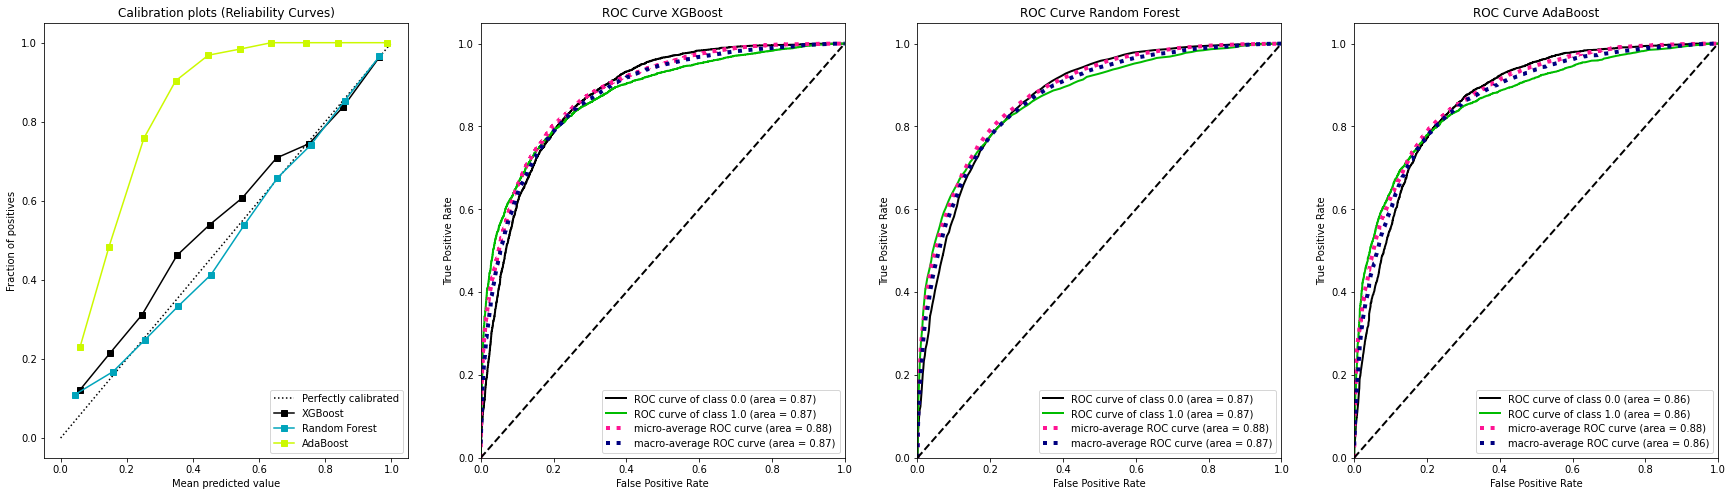

In [45]:
import scikitplot as skplt

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (30,8))

proba_xgboost = xgb.fit(X_train, y_train).predict_proba(X_test)
proba_randomf = rdf.fit(X_train, y_train).predict_proba(X_test)
proba_adaboost = adb.fit(X_train, y_train).predict_proba(X_test)

proba_list = [proba_xgboost, proba_randomf, proba_adaboost]
skplt.metrics.plot_calibration_curve(y_test,proba_list,description_models, figsize = (10,8), ax = ax[0])
skplt.metrics.plot_roc(y_test, proba_xgboost, ax = ax[1], title = 'ROC Curve XGBoost')
skplt.metrics.plot_roc(y_test, proba_randomf, ax = ax[2], title = 'ROC Curve Random Forest')
skplt.metrics.plot_roc(y_test, proba_adaboost, ax = ax[3], title = 'ROC Curve AdaBoost')

Los valores y formas de las curvas ROC para los tres modelos son similares por lo que desde esa perspectiva cualquier modelo es viable, tal y como se viene viendo.

Sin embargo, cuando se mira la curva de calibración, se observan diferencias significativas. Por un lado, el AdaBoost se encuentra lejos de un modelo perfectamente calibrado, por lo que queda descartado. 
Por otro lado, tanto XGBoost como Random Forest son modelos que están muy bien calibrados. Sin embargo, el último se encuentra ligeramente por encima del XGBoost por lo que es el modelo seleccionado.

## Optimización de parámetros

Ya seleccionado el modelo final, se procede a buscar la mejor combinacion de parámetros para ver si mejora la performance final.

In [46]:
from sklearn.model_selection import GridSearchCV
rdf = RandomForestClassifier()
param = dict()
param['criterion'] = ['gini', 'entropy']
param['n_estimators'] = [1, 2, 4, 8, 10, 16, 32, 64, 100, 200, 250, 300]
param['min_samples_split'] = [1,2,5,8,10,15,20,25,50,55,60,80,100]


gs = GridSearchCV(estimator = rdf, param_grid = param, scoring='f1', cv = 5, n_jobs = 3, verbose = 1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 312 candidates, totalling 1560 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  58 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 224 tasks      | elapsed: 10.1min
[Parallel(n_jobs=3)]: Done 474 tasks      | elapsed: 29.2min
[Parallel(n_jobs=3)]: Done 824 tasks      | elapsed: 48.5min
[Parallel(n_jobs=3)]: Done 1274 tasks      | elapsed: 91.1min
[Parallel(n_jobs=3)]: Done 1560 out of 1560 | elapsed: 117.5min finished


0.8485298381819522
{'criterion': 'entropy', 'min_samples_split': 80, 'n_estimators': 200}


Accuracy Score:  80.15814637734461
AUC Score:  87.48854113604555


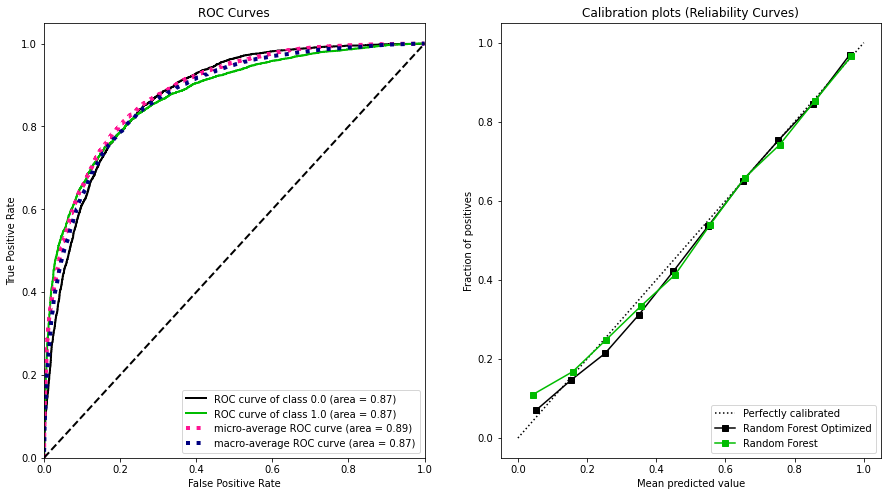

In [47]:
# Corro el modelo con los mejores parametros y se evalua la performance de este modelo 

rdf = RandomForestClassifier(criterion = 'gini', min_samples_split = 80, n_estimators = 300)
rdf.fit(X_train, y_train)
pred_rdf = rdf.predict(X_test)
probas_rdf_optimized = rdf.predict_proba(X_test) 
print("Accuracy Score: ", accuracy_score(y_test, pred_rdf)*100)
print("AUC Score: ", roc_auc_score(y_test, probas_rdf_optimized[:, 1])*100)

fig, ax = plt.subplots(nrows = 1, ncols  = 2, figsize = (15,8))
skplt.metrics.plot_roc(y_test, probas_rdf_optimized, ax = ax[0])
skplt.metrics.plot_calibration_curve(y_test,[probas_rdf_optimized,proba_randomf],clf_names = ['Random Forest Optimized', 'Random Forest'], figsize = (10,8), ax = ax[1])

No hubo gran mejora con la optimización de parámetros. Para intentar mejorar se aplican métodos de reducción de dimensionalidad (feature selection) y se estudia la posibilidad de realizar ingeniería de atributos creando nuevos features.

La primera opción es aplicar el algoritmo BORUTA que busca eliminar features irrelevantes.

Sin entrar en detalles, el algoritmo determina la "relevancia" de un atributo al comparar la importancia del mismo contra una "relevancia sombra" que no es más que la importancia de dicho atributo luego de haber mezclado sus valores (notar que para esto es necesario correr algún modelo como árbol de búsqueda o random forest por ejemplo).

Si la relevancia es mayor para el atributo original, entonces se toma como "importante" y si no, entonces es descartado, ya que el azar mismo es más importante que la variable.

## Set Up BORUTA

In [48]:
pip install boruta

     |████████████████████████████████| 61kB 8.8MB/s 


In [49]:
from boruta import BorutaPy

#rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced', max_depth = 5)
boruta_feature_selector = BorutaPy(rdf, n_estimators='auto', 
                                   verbose = 2, random_state = 4242, max_iter = 50, perc = 90)
boruta_feature_selector.fit(X_train, y_train)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	148
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	9 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	10 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	11 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	12 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	13 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	14 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	15 / 50
Confirmed: 	64
Tentative: 	10
Rejected: 	74
Iteration: 	16 / 50
Confirmed: 	64
Tentative: 	10
Reject

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=80,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=117, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7FB66D65A490,
                                          verbose=0, warm_start=False),
         max_iter=50, n_estimators

In [50]:
# Construyo el dataset con las columnas filtradas
X_filtered = boruta_feature_selector.transform(X_train)
X_test_filtered = boruta_feature_selector.transform(X_test)

# Obtengo las columnas finales 
features = [f for f in X.columns]
final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])

ROC AUC Score:  87.56597141051725


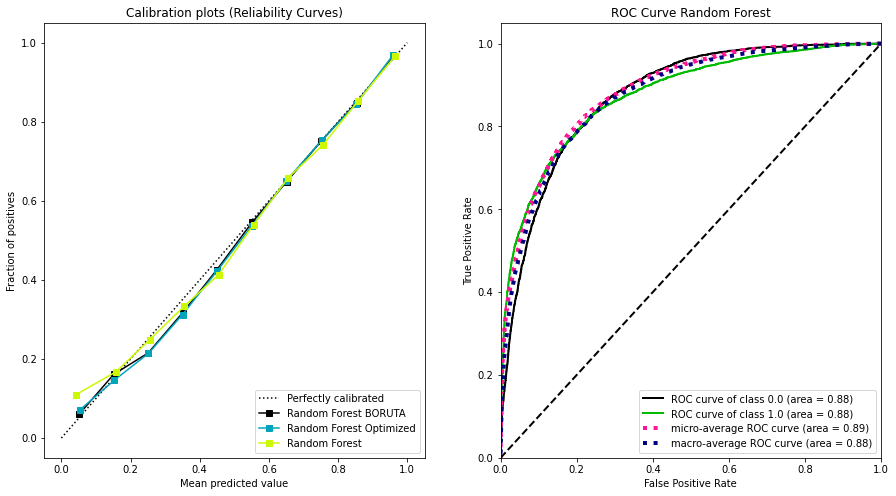

In [51]:
# Entreno sobre el dataset filtrado
rdf.fit(X_filtered, y_train)
probas_rdf_boruta = rdf.predict_proba(X_test_filtered)
# Observo resultados
print('ROC AUC Score: ', roc_auc_score(y_test, probas_rdf_boruta[:, 1])*100)

# Ploteo curva ROC y curva de calibracion
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))
skplt.metrics.plot_calibration_curve(y_test,[probas_rdf_boruta, probas_rdf_optimized, proba_randomf],clf_names = ['Random Forest BORUTA', 'Random Forest Optimized',
                                                                                                                  'Random Forest'], figsize = (10,8), ax = ax[0])
skplt.metrics.plot_roc(y_test, probas_rdf_boruta, ax = ax[1], title = 'ROC Curve Random Forest')


Si bien la performance general en términos de AUC no tuvo grandes variaciones, cuando se observa la curva de calibración se ve que hay cambios significativos entre los modelos básicos, el optimizado con todas las features y el filtrado mediante BORUTA. 

La diferencia entre los dos últimos no es significativa pero evidentemente el BORUTA aporta una cierta mejora.

## Feature Importance

Se busca entender cuáles son los atributos más importantes. Esto puede ser importante para futuros modelos o próximos pasos.

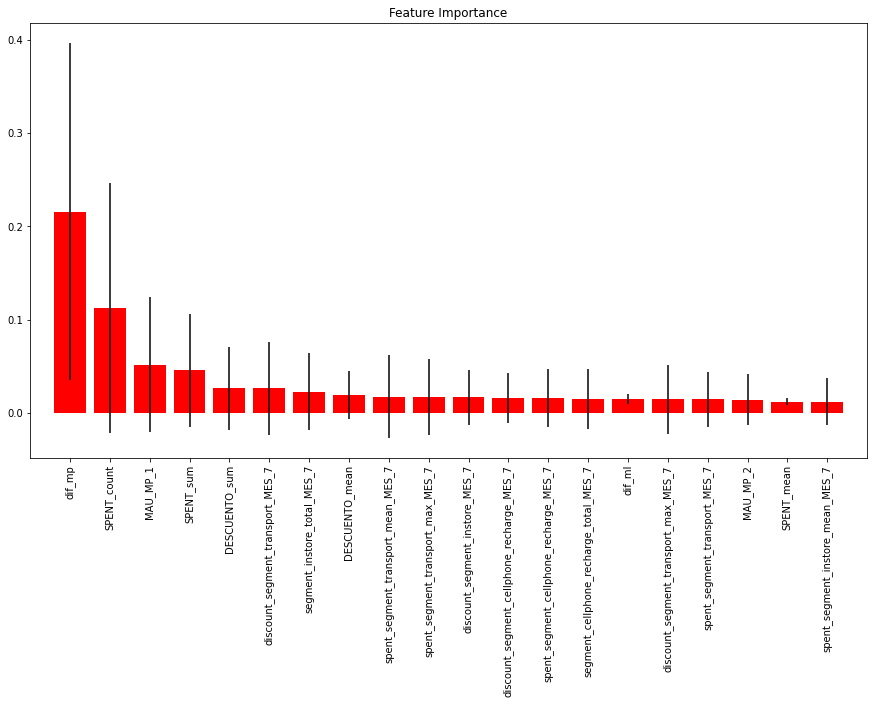

In [52]:
skplt.estimators.plot_feature_importances(rdf, feature_names=final_features, figsize = (15,8), x_tick_rotation = 90)

In [53]:
pip install eli5

     |████████████████████████████████| 112kB 31.7MB/s 


In [54]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rdf, random_state=1).fit(X_test_filtered, y_test)
eli5.show_weights(perm, feature_names = final_features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



Weight,Feature
0.0298 ± 0.0035,dif_mp
0.0086 ± 0.0025,SPENT_count
0.0017 ± 0.0015,segment_instore_total_MES_7
0.0016 ± 0.0013,dif_ml
0.0015 ± 0.0009,DESCUENTO_sum
0.0012 ± 0.0006,discount_segment_instore_MES_7
0.0012 ± 0.0019,MAU_MP_1
0.0011 ± 0.0012,spent_segment_utilities_max_MES_7
0.0008 ± 0.0008,discount_segment_utilities_max_MES_7
0.0007 ± 0.0007,segment_money_transfer_total_MES_7


Ambos metodos utilizados determinan que el atributo más importante es *dif_mp*, es decir, la diferencia de tiempo entre el último loggeo de un usuario y su última compra en MP.

Los demás atributos aportan en mayor o menor medida. Lo que si es interesante es que muchos atributos corresponden a los últimos meses previos a la baja. Esto confirma la sospecha de que la actividad en el último tiempo es la que debería ser más relevante. Esto sugiere que para una posible mejora sobre este modelo es darle ciertos pesos a los atributos de forma tal que valores más alejados "importen" menos que valores más recientes, de esta forma el modelo aprenderá a observar con mayor detalle estas observaciones.

# Conclusion

Luego de hacer distintas pruebas y comparar contra diferentes modelos, se obtuvo como resultado final que el modelo de RandomForest fue el que obtuvo mejores resultados, con un AUC promedio de 0.88 lo que se considera como muy satisfactorio. 

Adicionalmente se observa que el modelo esta muy bien calibrado, es decir, aquellos registros que predice con una determinada probabilidad de pertenecer a una clase, en líneas generales en la población se corresponde la misma proporción.

Lógicamente, el AUC es una métrica global del modelo, independiente del punto de corte que se use. Sin embargo, es decisión del negocio determinar la probabilidad mínima que maximice las ganancias en futuras campañas. Siguiendo esta idea sería posible realizar alguna especie de matriz de costos. 

El modelo tiene mucho margen de mejora, como se mencionó anteriormente, es posible agregarles distintos pesos a los valores para los distintos meses, de forma tal de darle prioridad a las interacciones más recientes. 

Por otro lado, no se hizo un análisis muy profundo sobre los *outliers*, si bien en líneas generales no es deseable eliminar estos registros, es importante tratarlos. No creo que aporten gran mejora, pero contribuiria a la consistencia de los datos. 

Se podrían tomar distintas ventanas de tiempo para evaluar si mejoran o no los resultados.

Adicionalmente, similar al gráfico que se realizó para ver las distribuciones de la variación de interacciones en MP en los distintos meses, agregaría las mismas métricas de variación para cada uno de los segmentos.

Como posibles datos adicionales, algunas variables que podrían aportar valor predictivo podrían ser:

* Clase de usuario (digital, mixto): En líneas generales, este índice o clasificador podría ser un indicativo de la probabilidad que hay de que un usuario consuma MP. Es poco probable (o no, debería chequearse) que una persona no tan digital encuentre MP muy práctico.

* Flag indicando si aprovecha o no las prommociones y ofertas de MP
* Flag indicando si recomendó (o se le recomendó) la app MP
* Entender cómo suele usar MP, si solamente a través de QR, mediante transferencias, etc.
* Muchas ofertas y descuentos en ML surgen por MP, linkear dichas interacciones de la app con sus interacciones de MP. Esto daría una idea de si el uso de MP viene motivado por mayores beneficios en ML.
* Cantidad de campañas e incentivos que recibió el usuario
* A través de los amigos es posible obtener un circulo de influencia que permita inferir el comportamiento de un usuario basado en el resto